In [14]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from scipy.optimize import curve_fit


from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry

from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, hstack, vstack
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.table import Table
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

In [15]:
I_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits'))[0]
U_cube = U_hdu.data[0]
V_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_V_Farcsec_fcube_cor.fits'))[0]
V_cube = V_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)
V_freqmean = np.nanmean(V_cube, axis=0)


I_wcs = WCS(I_hdu.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)
V_wcs = WCS(V_hdu.header)

In [16]:
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)
Linpol_hdu.writeto('Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

In [17]:
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

(2.2228118e-05, 2.056794e-05, 7.4738346e-06)


In [18]:
daofind = DAOStarFinder(fwhm=3.0, threshold=np.sqrt(12)*3*backgr_std)

mask = np.ones(linpol_intens_freqmean.shape, dtype=bool)
mask[1600:1700, 1250:1350] = False
mask[1100:1200, 1500:1600] = False
sources_compar = daofind(linpol_intens_freqmean - backgr_median, mask=mask)
for col in sources_compar.colnames:
    sources_compar[col].info.format = '%.8g'  # for consistent table output
print(sources_compar)

 id xcentroid ycentroid sharpness  ... sky      peak        flux       mag    
--- --------- --------- ---------- ... --- ------------- --------- -----------
  1 1574.1474 1124.9486 0.39922598 ...   0 0.00090003421  3.362515  -1.3166606
  2 1560.8153 1141.9812 0.39641346 ...   0 0.00036038106 1.2886927 -0.27537345
  3 1290.9782 1658.5458 0.39955294 ...   0  0.0015098529  5.629505  -1.8761755


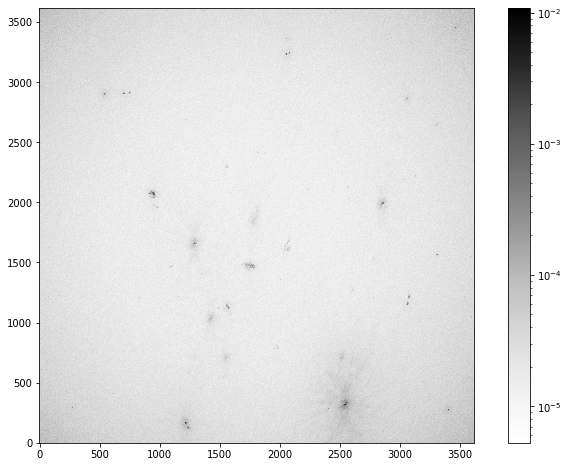

In [19]:
from photutils.aperture import CircularAperture

positions_compar = np.transpose((sources_compar['xcentroid'], sources_compar['ycentroid']))
apertures_compar = CircularAperture(positions_compar, r=7.)

plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()
apertures_compar.plot(color='blue', lw=0.1)
plt.savefig('ACO85_Linpol_FreqmeanSourcedetect.pdf', dpi=300)

In [20]:
annulus_apertures_compar = CircularAnnulus(positions_compar, r_in=8., r_out=13.)
apers_compar = [apertures_compar, annulus_apertures_compar]

def photometry(data_local, apers_local):
    phot_table = aperture_photometry(data_local, apers_local)
    bkg_mean = phot_table['aperture_sum_1'] / apers_local[1].area
    bkg_sum = bkg_mean * apers_local[0].area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    return(phot_table)

phot_table_compar = photometry(linpol_intens_freqmean, apers_compar)
print(phot_table_compar[2])

 id      xcenter            ycenter         aperture_sum_0      aperture_sum_1    residual_aperture_sum
           pix                pix                                                                      
--- ------------------ ----------------- ------------------- -------------------- ---------------------
  3 1290.9782154774423 1658.545823133161 0.06807782834650733 0.023175136993175374   0.05726276441635882


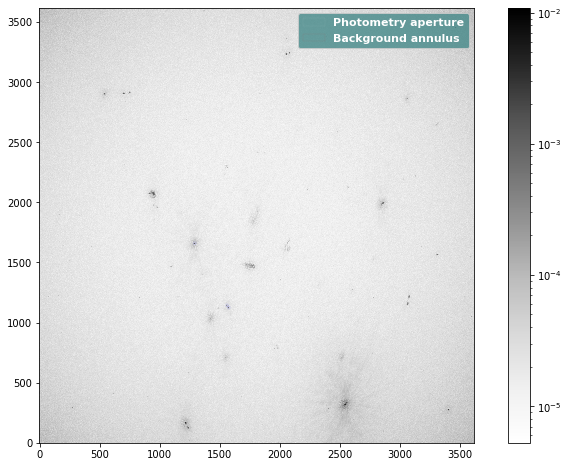

In [21]:
plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()

ap_patches = apertures_compar.plot(color='white', lw=0.05, label='Photometry aperture')
ann_patches_compar = annulus_apertures_compar.plot(color='blue', lw=0.05, label='Background annulus (VLA compar)')
handles_compar = (ap_patches_compar[0], ann_patches_compar[0])
plt.legend(facecolor='#458989', labelcolor='white', handles=handles, prop={'weight': 'bold', 'size': 11})
plt.savefig('ACO85_Linpol_Photometry.pdf', dpi=300)

In [22]:
I_phot_table_compar = np.zeros((12, len(sources_compar)))
Q_phot_table_compar = np.zeros((12, len(sources_compar)))
U_phot_table_compar = np.zeros((12, len(sources_compar)))
V_phot_table_compar = np.zeros((12, len(sources_compar)))

for n in range(12):
    I_slice_phot_compar = photometry(I_cube[n], apers_compar)
    Q_slice_phot_compar = photometry(Q_cube[n], apers_compar)
    U_slice_phot_compar = photometry(U_cube[n], apers_compar)
    V_slice_phot_compar = photometry(V_cube[n], apers_compar)
    for i in range(len(sources_compar)):
        I_phot_table_compar[n, i] = I_slice_phot_compar[i]['residual_aperture_sum']
        Q_phot_table_compar[n, i] = Q_slice_phot_compar[i]['residual_aperture_sum']
        U_phot_table_compar[n, i] = U_slice_phot_compar[i]['residual_aperture_sum']
        V_phot_table_compar[n, i] = V_slice_phot_compar[i]['residual_aperture_sum']

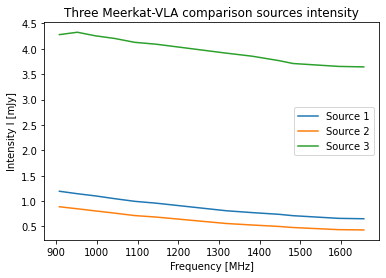

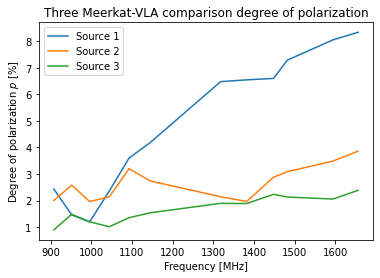

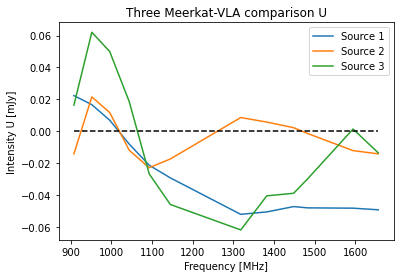

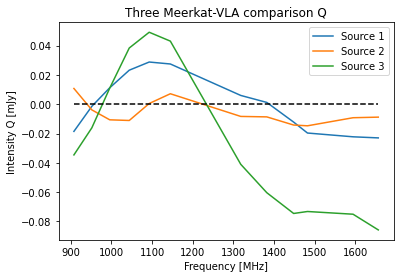

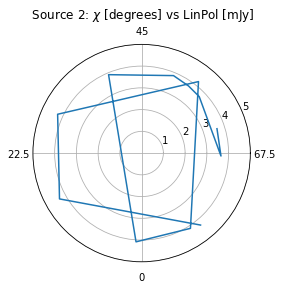

In [23]:
Pol_Angles_compar = 0.5*np.arctan(U_phot_table_compar/Q_phot_table_compar)
Linpol_compar = np.sqrt(U_phot_table_compar**2 + Q_phot_table_compar**2)
Freqs = np.array([908, 952, 996, 1044, 1093, 1145, 1318, 1382, 1448, 1482, 1594, 1656])# MHz

plt.title('Three Meerkat-VLA comparison sources intensity')
plt.plot(Freqs, I_phot_table_compar, label=['Source 1', 'Source 2', 'Source 3'])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity I [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat-VLA comparison degree of polarization')
plt.plot(Freqs, 100*Linpol_compar/I_phot_table_compar, label=['Source 1', 'Source 2', 'Source 3'])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Degree of polarization $p$ [%]')
plt.legend()
plt.show()

plt.title('Three Meerkat-VLA comparison U')
plt.plot(Freqs, U_phot_table_compar, label=['Source 1', 'Source 2', 'Source 3'])
plt.hlines(0, min(Freqs), max(Freqs), color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity U [mJy]')
plt.legend()
plt.show()

plt.title('Three Meerkat-VLA comparison Q')
plt.plot(Freqs, Q_phot_table_compar, label=['Source 1', 'Source 2', 'Source 3'])
plt.hlines(0, min(Freqs), max(Freqs), color='black', linestyle='dashed')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Intensity Q [mJy]')
plt.legend()
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles_compar[:,2], I_phot_table_compar[:,2])
ax.set_rmax(5)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([r'$0$', r'$22.5$', r'$45$', r'$67.5$'], fontsize=10)
ax.grid(True)
ax.set_title(r" Source 2: $\chi$ [degrees] vs LinPol [mJy]")
plt.show()